In [1]:
import numpy as np
import cv2
import scipy.stats as stats
import mpmath as mp
import matplotlib.pyplot as plt
import seaborn as sns
import skimage
from numba import jit, prange
import time

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

In [3]:
print(np.finfo(np.double).precision)

15


In [4]:
def see(img):
    plt.imshow(img)
    plt.show()

In [5]:
def getHSV_Image_and_Mask(img,mask):
    # import images (will be in bgr because of cv2)
    img_bgr = cv2.imread(img)
    mask_bgr = cv2.imread(mask)

    # make a true/false array since mask is assumed to be a png.
    m = mask_bgr[:,:,0]>1
    
    # get r,g, and b of img_bgr:
    img_r = img_bgr[:,:,2]
    img_g = img_bgr[:,:,1]
    img_b = img_bgr[:,:,0]
    
    # convert img_bgr to HSV:
    img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
    
    # get H, S and V of img_hsv
    img_H = img_hsv[:,:,0]
    img_S = img_hsv[:,:,1]
    img_V = img_hsv[:,:,2]
    
#     print('r,g,b,h,s,v, mask')
#     see(img_r)
#     see(img_g)
#     see(img_b)
#     see(img_H)
#     see(img_S)
#     see(img_V)
#     see(m)
    
    return(img_r,img_g,img_b,img_H,img_S,img_V, m)

In [6]:
def extract_coins(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location
    i, j = np.where(mask == True)
    coins=img[i,j]
    return coins

In [7]:
def extract_desk(img, mask):
#     returns location of pixels in coins, given a mask
#    assumes 255 corresponds to a coin pixel location
    i, j = np.where(mask == False)
    desk=img[i,j]
    return desk

In [8]:
def getHSV_unraveled(img):
    # import images (will be in bgr because of cv2)
    img_bgr = cv2.imread(img)

    
    # get r,g, and b of img_bgr:
#     img_r = img_bgr[:,:,2]
#     img_g = img_bgr[:,:,1]
#     img_b = img_bgr[:,:,0]
    
    # convert img_bgr to HSV:
    img_hsv = cv2.cvtColor(img_bgr,cv2.COLOR_BGR2HSV)
    
    # get H, S and V of img_hsv
    img_H = np.ravel(img_hsv[:,:,0])
    img_S = np.ravel(img_hsv[:,:,1])
    img_V = np.ravel(img_hsv[:,:,2])

    data = np.stack((img_H,img_S,img_V))
    return(data)

# EM Algorithm ( Fitting MoG)
## based on pseudocode from Algorithms Implementations in MATLAB by Stavrev and Prince, <br> Algorithms (Prince), Algorithm 7.1, <br> and equations from CVM (Prince) Chapter 7

In [9]:
def E(X, K,μ,Σ,λ):
    
    
    #  Compute numerator for qi(hi) = Pr(hi = k|xi ,θ[t]):
    #  λ_k*Norm_xi[μ_k , Σ_k ]
    # for each Gaussian (k)
    numerators = np.zeros((K,X.shape[0]))
    for k in range(K):
        numerators[k] = stats.multivariate_normal.pdf(X, μ[k], Σ[k],allow_singular=True)*λ[k]
        # this part is relatively fast


    denominator = np.sum(numerators,axis=0)
    print('denominator',denominator.shape)
    print('numerators',numerators.shape)

    # Compute posterior (responsibilities) by normalizing
    responsibilities = numerators/denominator
    print(responsibilities[0])
    print(np.sum(responsibilities[0]))
#     print('responsibilities',responsibilities.shape)
    rsum = np.sum(responsibilities,axis=1)
    print('rsum',rsum)
    return responsibilities, rsum

In [10]:

@jit
def EM(X, K, precision):
#     Input: X - each row is one datapoint.
#            K - number of Gaussians in the mixture.
#            precision - the algorithm stops when the difference between 
#                        the previous and the new likelihood is < precision.
#                        Typically this is a small number like 0.01. 
#    Output:
#        λ      - λ(k) is the weight for the k-th Gaussian.
#        μ      - mu(k,:) is the mean for the k-th Gaussian.
#        Σ      - Σ{k} is the covariance matrix for the k-th Gaussian.
#     rs = np.random.RandomState(seed=0)

    # Initialize λ to 1/K (footnote in algorithm 7.1)
    λ = (1/K)*np.ones(K)
#     print('original λ,λ.shape',λ,λ.shape)

    # Initialize μ to the values of K randomly chosen (unique) datapoints 
    # Note that X must have more than K entries for this to work.
    μ = X[np.random.choice(len(X), size=K, replace=False)].astype('float64')
    print('original μ,μ.shape',μ,μ.shape)

    # Initialize the variances in sig to the variance of the dataset.
    initial_variance = np.cov(X.T) # X in cov and X in pdf, must be different to each other (i.e X xor X.T). very stupid.
    Σ = np.zeros((K, initial_variance.shape[1], initial_variance.shape[1]))
    for i in range(K):
        Σ[i,:,:] = initial_variance
    
    print('Σ,Σ.shape',Σ,Σ.shape)
#---------------------   EM algorithm: ---------------------------------------------------
    
    tol = 1000000 # random init ?? maybe not. Let's see
    iterations = 0
    MAX_ITERATIONS = 10
    while(np.abs(tol) > precision):
        
#---------------------   EM step: ---------------------------------------------------

    # Expectation Step
        
        #  Compute numerator for qi(hi) = Pr(hi = k|xi ,θ[t]):
        #  λ_k*Norm_xi[μ_k , Σ_k ]
        # for each Gaussian (k)
#         numerators = np.zeros((K,X.shape[0]))
#         for k in range(K):
#             numerators[k] = stats.multivariate_normal.pdf(X, μ[k], Σ[k],allow_singular=True)*λ[k]
            
            
#         denominator = np.sum(numerators,axis=0)

#         # Compute posterior (responsibilities) by normalizing
#         responsibilities = numerators/denominator
#         print('responsibilities',responsibilities)
#         rsum = np.sum(responsibilities,axis=1)



        responsibilities,rsum = E(X, K,μ,Σ,λ)



    



        
    # Maximization Step (eqn (7.19) in CVM (Prince))
        
        
        newmu = np.zeros((K,X.shape[1]))
        
        for k in range(K):
        # update λ's
            print('before λ[k]',λ[k])
            λ[k] = rsum[k]/np.sum(rsum) 
            print('λ[k]',λ[k])
        # update μ's
            t0 = time.time()

#             for i in range(X.shape[0]):
# #                 pass
#             print('rsum[k]',rsum[k])
            newmu[k] = np.sum(responsibilities[k].reshape(len(X),1)*X, axis = 0 ) /rsum[k]
#     newmu[k] +responsibilities[k,i]*X[i]
                  
        
#             newmu[k] = newmu[k]/rsum[k]
#             print('newmu[',k,']/rsum',newmu[k])
            μ[k] = newmu[k]
            t1 = time.time()
            total = t1-t0
#             print('total time for μ[k] ',total)
            print('μ[k]',μ[k])


        # update Σ's 
            t0 = time.time()
#             Σ[k] = 0.0
            
            Σ[k] = np.dot((responsibilities[k].reshape(len(X),1)*(X-μ[k])).T, X-μ[k])/rsum[k]
#             print('Σ,Σ.shape',Σ,Σ.shape)
#             for i in range(X.shape[0]):
# # #                 pass
#                 Σ[k] += responsibilities[k,i] * (X[i]-μ[k]).reshape((-1,1))@(X[i]-μ[k]).reshape((-1,1)).T

#             Σ[k] = Σ[k]/rsum[k]
            
            t1 = time.time()
            total = t1-t0
#             print('total time for Σ[k]',total)  




# print('Σ[k],Σ[k].shape',Σ[k],Σ[k].shape)
#         print('Σ,Σ.shape',Σ,Σ.shape)

#----------- End M step


#  ------------------------------- END OF EM STEP _____________________________________


       # Compute the log likelihood L. Note this step is only in the Algorithms (Prince) book. Not the Prince textbook.
        # This Prince guy is pretty inconsistent/infuriating. Even if he is a Cambridge grad.
        
        temp = np.zeros((K,X.shape[0]))
        for k in range(K):
#             print('Σ[k],det',Σ[k],np.linalg.det(Σ[k]))

            temp[k] = stats.multivariate_normal.pdf(X, μ[k], Σ[k],allow_singular=True)*λ[k]
#         print('temp before, shape',temp, temp.shape)
        temp = np.sum(temp,0) # sum the K rows
#         print('temp, shape',temp, temp.shape)
        temp = np.log(temp) # take the log of each element
#         print('temp log, shape',temp, temp.shape)
        L = sum(temp)
#         print('likelihood, shape:',L,L.shape)
        
        
        
        
        
        iterations += 1
        if(np.abs(L - tol) < precision):
            print('iterations:', iterations,'\n log-likelihood:', L, "\n tol test:",np.abs(L - tol))
            break
        else:
            print('iterations',iterations)
            
            print('log-likelihood:', tol)
            print('error:', np.abs(L - tol))
            tol = L
        
#         print('λ:',λ,'\n μ:',μ,'\n Σ:',Σ)
# ----------- End While loop
    
    
        
        
#     print('λ:',λ,'\n μ:',μ,'\n Σ:',Σ)
    return λ,μ,Σ

In [11]:
def fit_MoG(coins, desk, K, colour_space='hsv', precision=0.1):


#------------------------------ Data Extraction-----------------------------------------------------

#     # get channels from test_image:
#     r,g,b,h,s,v, mask = getHSV_Image_and_Mask(train_image, train_mask)
    
    
#     # seperate coins in each channel: Note this will make the image 1 D
#     # coin data
#     data1 = extract_coins(r,mask)[:int(0.01*pixels*r.size)]
#     data2 = extract_coins(g,mask)[:int(0.01*pixels*r.size)]
#     data3 = extract_coins(b,mask)[:int(0.01*pixels*r.size)]
#     data4 = extract_coins(h,mask)[:int(0.01*pixels*r.size)]
#     data5 = extract_coins(s,mask)[:int(0.01*pixels*r.size)]
#     data6 = extract_coins(v,mask)[:int(0.01*pixels*r.size)]

#     # desk data
#     desk1 = extract_desk(r,mask)[:int(0.01*pixels*r.size)]
#     desk2 = extract_desk(g,mask)[:int(0.01*pixels*r.size)]
#     desk3 = extract_desk(b,mask)[:int(0.01*pixels*r.size)]
#     desk4 = extract_desk(h,mask)[:int(0.01*pixels*r.size)]
#     desk5 = extract_desk(s,mask)[:int(0.01*pixels*r.size)]
#     desk6 = extract_desk(v,mask)[:int(0.01*pixels*r.size)]
    

# #     Use user-specified colour_space:
#     if(colour_space=='rgb'):
#         coin1 = data1
#         coin2 = data2
#         coin3 = data3
    
#         deskA = desk1
#         deskB = desk2
#         deskC = desk3
        
#         coins = np.stack((coin1,coin2,coin3))
#         desk = np.stack((deskA,deskB,deskC))
        
#     elif(colour_space == 'hsv'):
#         coin1 = data4
#         coin2 = data5
#         coin3 = data6
        
#         deskA = desk4
#         deskB = desk5
#         deskC = desk6
        
#         coins = np.stack((coin1,coin2,coin3))
#         desk = np.stack((deskA,deskB,deskC))
        
#     elif(colour_space == 'rgbhsv'):
#         coin1 = data1
#         coin2 = data2
#         coin3 = data3
    
#         deskA = desk1
#         deskB = desk2
#         deskC = desk3
    
#         coin4 = data4
#         coin5 = data5
#         coin6 = data6
        
#         deskD = desk4
#         deskE = desk5
#         deskF = desk6
    
#         # Stack the data into a matrix with 1 row per channel and num_pixels columns
#         coins = np.stack((coin1,coin2,coin3,coin4,coin5,coin6))
#         desk = np.stack((deskA,deskB,deskC,deskD,deskE,deskF))

        
# --------------- Modelling -----------------------------------------------------------------------
    print('coins shape',coins.shape)
    # Get MoG for coins:
    λc,μc,Σc = EM(coins.T, K, precision)

    # Get MoG for desk:
    λd,μd,Σd = EM(desk.T, K, precision)
        
        
    # Calculate Prior
#     prior = coin1.size/r.size # ratio of coin_pixels: total_pixels.
        
        
    print('λc,μc,Σc,λd,μd,Σd',λc,μc,Σc,λd,μd,Σd)
    return λc,μc,Σc,λd,μd,Σd

In [12]:
# # asdf = fit_MoG(t.T[:100,:], 2, 0.001)
# λ,μ,Σ = fit_MoG(t.T, 2, 0.1)
# prior,λc,μc,Σc,λd,μd,Σd = fit_MoG('Training/t1.jpg', 'Labels/l1.png',2, 0.1,100)
# A = fit_MoG('Training/t0.jpg', 'Labels/l0.png',2)

# TODO: 
## 1. Get all coin and desk pixels from 100 images and concatenate them into 2 datasets (coins and pixels)
## 2. Check distributions for different coins in report
## 3. Do edge detector to improve results
## 4 .Do diagonal covariance

## Try dask for loop
https://pythonhealthcare.org/2018/11/25/99-parallel-processing-functions-and-loops-with-dask-delayed-method/

In [13]:
def Bayes_Formula_MoG(coin_dist,prior,desk_dist):     
        Pr_coin = (prior*coin_dist)/ ( ( (1-prior)*desk_dist) + (prior*coin_dist) )
        return Pr_coin


In [14]:
def stupid_classify(Pr_coin):
    return np.greater(Pr_coin, 0.5)

In [15]:
def accuracy(test, mask):
        return (np.sum(test == mask)/(test.size))*100

In [16]:
def test_MoG(test_image,test_mask,prior,λc,μc,Σc,λd,μd,Σd,colour_space='hsv',accuracy_check=True):
    
    # get channels from test_image:
    original = cv2.imread(test_image)
    r,g,b,h,s,v, mask = getHSV_Image_and_Mask(test_image, test_mask)
    


#     Use user-specified colour_space:
    # seperate test image into channels and flatten them:

    if(colour_space=='rgb'):
        data1 = np.ravel(r)
        data2 = np.ravel(g)
        data3 = np.ravel(b)
        data = np.stack((data1,data2,data3))
      
    elif(colour_space == 'hsv'):
        data1 = np.ravel(h)
        data2 = np.ravel(s)
        data3 = np.ravel(v)
        data = np.stack((data1,data2,data3))
    elif(colour_space == 'rgbhsv'):
        data1 = np.ravel(r)
        data2 = np.ravel(g)
        data3 = np.ravel(b)
        data4 = np.ravel(h)
        data5 = np.ravel(s)
        data6 = np.ravel(v)
        data = np.stack((data1,data2,data3,data4,data5,data6))

    
    
    
    
    # Get predicitive density using parameters generated by the user-specified method:
    

    # Using equation (7.52) we sum over the  k parameters (liklihoods of each world state)
    # initialize the arrays 
    coin_dist = stats.multivariate_normal.pdf(data.T, μc[0], Σc[0])*λc[0]
    desk_dist = stats.multivariate_normal.pdf(data.T, μd[0], Σd[0])*λd[0]
    
    for k in range(1,len(λc)):     # len(λ)= number of Gaussians
        print('len(λ)',len(λc))
        print('len(μc)',len(μc))
        print('k',k)
        coin_dist += stats.multivariate_normal.pdf(data.T, μc[k], Σc[k])*λc[k]
        desk_dist += stats.multivariate_normal.pdf(data.T, μd[k], Σd[k])*λd[k]    

        
    # prior
    teepa = Bayes_Formula_MoG(coin_dist,prior,desk_dist)
    nala = np.reshape(stupid_classify(teepa),r.shape)
    see(original[:,:,::-1])
    see(nala)
    if(accuracy_check):
        acc = accuracy(nala, mask)

        print("Accuracy:",acc,"%")
        return nala, acc
    
    
    return nala

    

# Concat training data

In [17]:
def concat_data(num_images,sampling_number,colour_space='hsv'):
    
    coinH = []
    coinS = []
    coinV = []

    deskH = []
    deskS = []
    deskV = []
    
    coinR = []
    coinG = []
    coinB = []

    deskR = []
    deskG = []
    deskB = []
    
    num_coins = 0 
    num_desk = 0 
    # loop through each image:
    for i in range(num_images+1):
    # Get coin pixels in image: Note this will make the image 1 D
    # coin data
        mask = 'Labels/l'+str(i)+'.png'
        img = 'Training/t'+str(i)+'.jpg'
        r,g,b,h,s,v, m = getHSV_Image_and_Mask(img, mask)
        
        if(colour_space=='hsv'):
            teepa1=(extract_coins(h, m))
            teepa2=(extract_coins(s, m))
            teepa3=(extract_coins(v, m))
        
            nala1=(extract_desk(h, m))
            nala2=(extract_desk(s, m))
            nala3=(extract_desk(v, m))
        
            num_coins += len(teepa1)
            num_desk += len(nala1)

            random_samples_coins = np.random.choice(len(teepa1),min(sampling_number,len(teepa1)), replace=False)

            coinH.extend(teepa1[random_samples_coins])
            coinS.extend(teepa2[random_samples_coins])
            coinV.extend(teepa3[random_samples_coins])


            random_samples_desk = np.random.choice(len(nala1),min(sampling_number,len(nala1)), replace=False)

            deskH.extend(nala1[random_samples_desk])
            deskS.extend(nala2[random_samples_desk])
            deskV.extend(nala3[random_samples_desk])
        
        elif(colour_space=='rgb'):
            teepa1=(extract_coins(r, m))
            teepa2=(extract_coins(g, m))
            teepa3=(extract_coins(b, m))
        
            nala1=(extract_desk(r, m))
            nala2=(extract_desk(g, m))
            nala3=(extract_desk(b, m))            
            
            
            num_coins += len(teepa1)
            num_desk += len(nala1)

            random_samples_coins = np.random.choice(len(teepa1),min(sampling_number,len(teepa1)), replace=False)

            coinH.extend(teepa1[random_samples_coins])
            coinS.extend(teepa2[random_samples_coins])
            coinV.extend(teepa3[random_samples_coins])


            random_samples_desk = np.random.choice(len(nala1),min(sampling_number,len(nala1)), replace=False)

            deskH.extend(nala1[random_samples_desk])
            deskS.extend(nala2[random_samples_desk])
            deskV.extend(nala3[random_samples_desk])
            
            
            
            
        elif(colour_space=='rgbhsv'):
            teepa1=(extract_coins(h, m))
            teepa2=(extract_coins(s, m))
            teepa3=(extract_coins(v, m))

            nala1=(extract_desk(h, m))
            nala2=(extract_desk(s, m))
            nala3=(extract_desk(v, m))

            teepa4=(extract_coins(r, m))
            teepa5=(extract_coins(g, m))
            teepa6=(extract_coins(b, m))
        
            nala4=(extract_desk(r, m))
            nala5=(extract_desk(g, m))
            nala6=(extract_desk(b, m))   
        
            num_coins += len(teepa1)
            num_desk += len(nala1)

            random_samples_coins = np.random.choice(len(teepa1),min(sampling_number,len(teepa1)), replace=False)

            coinH.extend(teepa1[random_samples_coins])
            coinS.extend(teepa2[random_samples_coins])
            coinV.extend(teepa3[random_samples_coins])
            coinR.extend(teepa4[random_samples_coins])
            coinG.extend(teepa5[random_samples_coins])
            coinB.extend(teepa6[random_samples_coins])

            random_samples_desk = np.random.choice(len(nala1),min(sampling_number,len(nala1)), replace=False)

            deskH.extend(nala1[random_samples_desk])
            deskS.extend(nala2[random_samples_desk])
            deskV.extend(nala3[random_samples_desk])
            deskR.extend(nala4[random_samples_desk])
            deskG.extend(nala5[random_samples_desk])
            deskB.extend(nala6[random_samples_desk])        
        

    

    prior = num_coins/(num_coins+num_desk)
    
    
    
    if(colour_space=='rgbhsv'):
        coins = np.stack([np.array(coinR),np.array(coinG),np.array(coinB),np.array(coinH),np.array(coinS),np.array(coinV)])
        desk = np.stack([np.array(deskR),np.array(deskG),np.array(deskB),np.array(deskH),np.array(deskS),np.array(deskV)])
    else:
        coins = np.stack([np.array(coinH),np.array(coinS),np.array(coinV)])
        desk = np.stack([np.array(deskH),np.array(deskS),np.array(deskV)])
    
    
    
    
    return coins, desk, prior

In [44]:
A=concat_data(100,1000,colour_space='rgbhsv')

In [45]:
A[1].shape

(6, 101000)

In [43]:
# fit_MoG(coins, desk, K (Number of Guassians), colour_space='hsv',precision=0.1)

λc,μc,Σc,λd,μd,Σd = fit_MoG(A[0],A[1],10, colour_space='rgbhsv',precision=100)

coins shape (6, 50)
original μ,μ.shape [[125. 125. 106.  30.  39. 125.]
 [170. 200. 202.  92.  40. 202.]
 [255. 254. 231.  29.  24. 255.]
 [195. 200. 169.  35.  40. 200.]
 [197. 203. 199.  70.   8. 203.]
 [223. 215. 183.  24.  46. 223.]
 [252. 255. 251.  53.   4. 255.]
 [211. 211. 211.   0.   0. 211.]
 [173. 167. 135.  25.  56. 173.]
 [ 68.  68.  66.  30.   8.  68.]] (10, 6)
Σ,Σ.shape [[[1529.74857143 1496.56816327 1532.78122449   59.32244898 -184.69632653
   1509.45795918]
  [1496.56816327 1620.49836735 1769.80897959  331.65102041 -278.26653061
   1588.13714286]
  [1532.78122449 1769.80897959 2099.48734694  639.66938776 -527.23510204
   1685.00489796]
  [  59.32244898  331.65102041  639.66938776  898.09183673 -323.46326531
    252.27346939]
  [-184.69632653 -278.26653061 -527.23510204 -323.46326531  487.97102041
   -181.97877551]
  [1509.45795918 1588.13714286 1685.00489796  252.27346939 -181.97877551
   1587.21469388]]

 [[1529.74857143 1496.56816327 1532.78122449   59.32244898 -184.

len(λ) 10
len(μc) 10
k 1
len(λ) 10
len(μc) 10
k 2
len(λ) 10
len(μc) 10
k 3
len(λ) 10
len(μc) 10
k 4
len(λ) 10
len(μc) 10
k 5
len(λ) 10
len(μc) 10
k 6
len(λ) 10
len(μc) 10
k 7
len(λ) 10
len(μc) 10
k 8
len(λ) 10
len(μc) 10
k 9


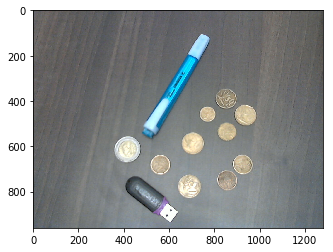

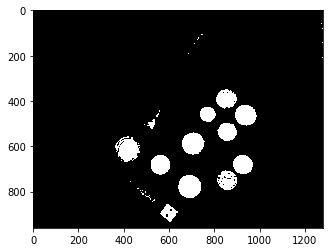

In [206]:
# test_MoG(test_image,test_mask,prior,λc,μc,Σc,λd,μd,Σd,colour_space='hsv',accuracy_check=True):

C = test_MoG('Training/t181.jpg','Labels/l206.png',A[2],λc,μc,Σc,λd,μd,Σd, colour_space='rgb',accuracy_check=False)

In [198]:
O = cv2.morphologyEx(255*C.astype('uint8'), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4)) )

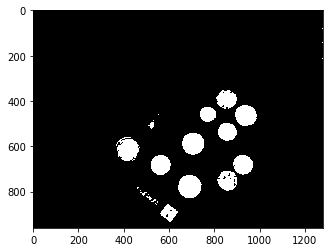

In [199]:
see(O)

In [18]:
#  1 D stuff

In [ ]:
λc,μc,Σc,λd,μd,Σd = fit_MoG(A[0],A[1],10, colour_space='hsv',precision=100)

In [27]:
# MOG Split functions for 1D data

In [28]:
def E(X, K,μ,Σ,λ):
    
    
    #  Compute numerator for qi(hi) = Pr(hi = k|xi ,θ[t]):
    #  λ_k*Norm_xi[μ_k , Σ_k ]
    # for each Gaussian (k)
    numerators = np.zeros((K,X.shape[0]))
    for k in range(K):
        numerators[k] = stats.multivariate_normal.pdf(X, μ[k], Σ[k],allow_singular=True)*λ[k]
        # this part is relatively fast


    denominator = np.sum(numerators,axis=0)
#     print('denominator',denominator.shape)
#     print('numerators',numerators.shape)

    # Compute posterior (responsibilities) by normalizing
    responsibilities = numerators/denominator
#     print(responsibilities[0])
#     print(np.sum(responsibilities[0]))
#     print('responsibilities',responsibilities.shape)
    rsum = np.sum(responsibilities,axis=1)
    print('responsibilities',responsibilities)
    return responsibilities

In [22]:
def M(X, K,responsibilities,λ,μ,Σ):
       # Maximization Step (eqn (7.19) in CVM (Prince))

    rsum = np.sum(responsibilities,axis=1)
#         newmu = np.zeros((K,X.shape[1]))
    # if X is 1D use this:
    newmu = np.zeros((K,1 ))

    for k in range(K):
    # update λ's
#         print('before λ[k]',λ[k])
        λ[k] = rsum[k]/np.sum(rsum) 
#         print('λ[k]',λ[k])
    # update μ's

#             for i in range(X.shape[0]):
# #                 pass
#             print('rsum[k]',rsum[k])
        for i in range(len(X)):
            newmu[k] += (responsibilities[k,i]*X[i])
#     newmu[k] +responsibilities[k,i]*X[i]
        newmu[k] =  newmu[k] /rsum[k]

#             newmu[k] = newmu[k]/rsum[k]
#             print('newmu[',k,']/rsum',newmu[k])
        μ[k] = newmu[k]
#             print('total time for μ[k] ',total)
        print('μ[k]',μ[k])


    # update Σ's 
#             Σ[k] = 0.0
        for i in range(len(X)):
            Σ[k] += responsibilities[k,i]*((X[i]-μ[k])**2)
        Σ[k] /= rsum[k]


#             print('total time for Σ[k]',total)  
    print('λ',λ,'\n μ',μ,'\n Σ',Σ)
    return λ,μ,Σ


In [23]:
data = np.array([0.0,0.1,1.1,1.2,0.3])

In [24]:
# E(X, K,μ,Σ,λ):
#  mu and sigma must be rows, each row represents the parameter for each gaussian
# data must be a numpy array!
teepa = E(data,2,[[0.5],[0.75]],[ [0.4],[ 0.3]], [0.5,0.5])

responsibilities [[0.61802151 0.58911926 0.40379569 0.39679411 0.5358531 ]
 [0.38197849 0.41088074 0.59620431 0.60320589 0.4641469 ]]


In [25]:
resp = np.array([[0.606,0.593,0.402,0.378,0.563],[0.394,0.407,0.598,0.622,0.437]])

In [26]:
# initialise some parameters:
λ = np.zeros((2))
μ = np.zeros((2,1))
Σ = np.zeros((2,1))

In [29]:
# M(X, K,responsibilities):
mstep_teepa = M(data,2,resp,λ,μ,Σ)

μ[k] [0.44217152]
μ[k] [0.64117168]
λ [0.5084 0.4916] 
 μ [[0.44217152]
 [0.64117168]] 
 Σ [[0.23223415]
 [0.26532686]]
